# Image Classification with DL for Online Marketing Campaigns.

Say there is an online store that would like to target customers to improve retention rates or increase customer engagment with offer campaigns or new products' recommendations. Shared images on social media may provide a significant amount of information of customer preferences in real time. 

this can be integrated with other applications and website to make a powerfull classification based of interests.

Further expansion on the idea is to utalise the network topology "Structure".

This will:
* Maximise marketing efficency.
* Reducing cost by targeting influencers in communities in the network. 

In [8]:
# imports:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai import *
from fastai.metrics import error_rate

In [9]:
#batch size  (bs = 32):
bs = 8   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data:

The data was scraped from both **Google Images**, and **Image_net**:

**Image_net** is an image database organized according to the WordNet hierarchy (currently only the nouns), in which each node of the hierarchy is depicted by hundreds and thousands of images. 

We used it because the model is built with the images from this library, and will do better when training the last layer with the classes we chose.

The Classes:
* **Watches:** 1,301 images.
* **Sunglasses:** 1,129 images.
* **Hats:** 804 images.
* **Coffee:** 1,443 images.
* **Cake:** 802 images.

### Getting the data:
to train the last layer with.

In [23]:
#setting the file path:
from pathlib import Path
path = Path(u'C:','/','Users','creed','Desktop','project')

In [24]:
path_img = path/'new dataset 2'

In [25]:
fnames = get_image_files(path_img)
fnames[-5:]

[WindowsPath('C:/Users/creed/Desktop/project/new dataset 2/watch1297.jpeg'),
 WindowsPath('C:/Users/creed/Desktop/project/new dataset 2/watch1298.jpeg'),
 WindowsPath('C:/Users/creed/Desktop/project/new dataset 2/watch1299.jpeg'),
 WindowsPath('C:/Users/creed/Desktop/project/new dataset 2/watch1300.jpeg'),
 WindowsPath('C:/Users/creed/Desktop/project/new dataset 2/watch1301.jpeg')]

In [26]:
# Using regex to get all the names/image class by their names:

np.random.seed(2)

pat = r'/([^/]+)\d{4}.jpeg$'


In [27]:
# Loading and splitting (standard 20, 80) our data and setting the parameters:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [28]:
data

ImageDataBunch;

Train: LabelList (4336 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cake,cake,cake,cake,cake
Path: C:\Users\creed\Desktop\project\new dataset 2;

Valid: LabelList (1084 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sunglasses,cake,hat,sunglasses,cake
Path: C:\Users\creed\Desktop\project\new dataset 2;

Test: None

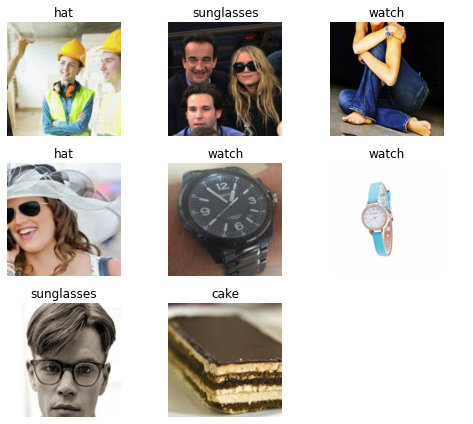

In [29]:
#show some of the data (a single batch):
data.show_batch(rows=3, figsize=(7,6))

In [20]:
print(data.classes)
len(data.classes),data.c

['cake', 'coffee', 'hat', 'sunglasses', 'watch']


(5, 5)

## Training: resnet34
Now we will start training the model. of convolutional NN with 34 hidden layers, with our own specific classes. 

In [30]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [32]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [33]:
# We will train for 4 epochs (4 cycles through all our data):

learn.fit_one_cycle(4)

In [34]:
#saving the first model 
learn.save('project-34') # ['hat', 'sunglasses', 'watch','coffee','cake']

## Results

In [35]:
# using the "ClassificationInterpretation", to interpret the worst case scenarios:

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

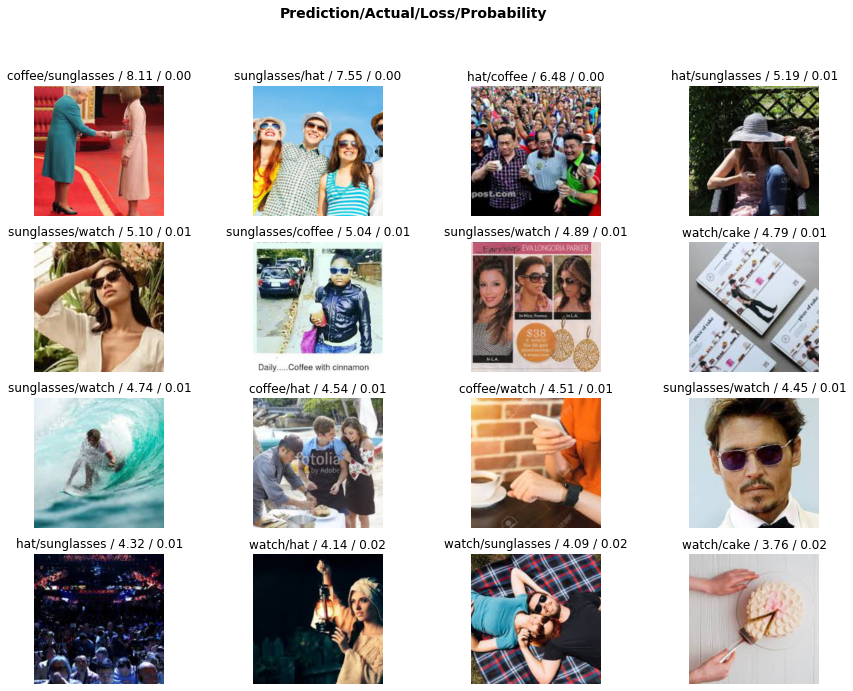

In [36]:
interp.plot_top_losses(16, figsize=(15,11))

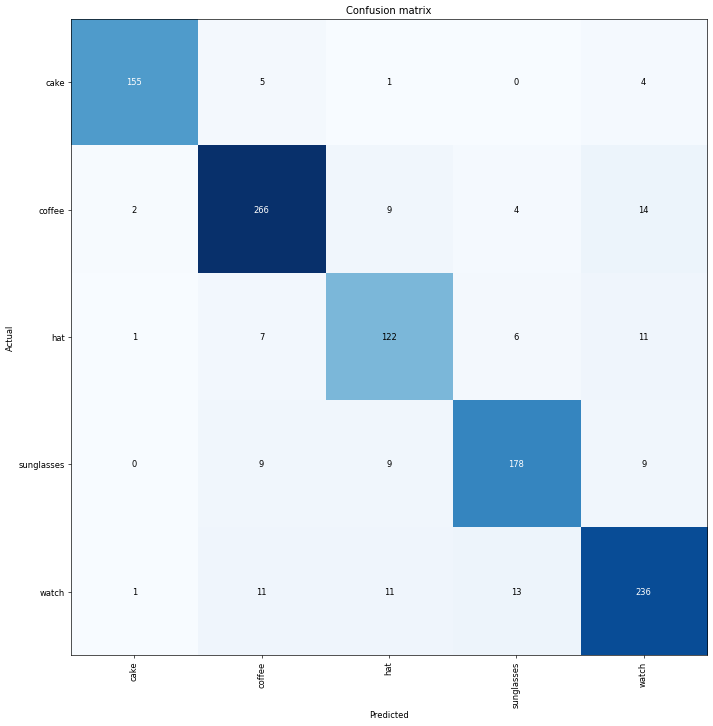

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#The diagonal is darker threfore most predicitions were correct.

In [39]:
interp.most_confused(min_val=2)

[('coffee', 'watch', 14),
 ('watch', 'sunglasses', 13),
 ('hat', 'watch', 11),
 ('watch', 'coffee', 11),
 ('watch', 'hat', 11),
 ('coffee', 'hat', 9),
 ('sunglasses', 'coffee', 9),
 ('sunglasses', 'hat', 9),
 ('sunglasses', 'watch', 9),
 ('hat', 'coffee', 7),
 ('hat', 'sunglasses', 6),
 ('cake', 'coffee', 5),
 ('cake', 'watch', 4),
 ('coffee', 'sunglasses', 4),
 ('coffee', 'cake', 2)]

## fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [46]:
learn.unfreeze()

In [47]:
learn.fit_one_cycle(1) # additional epoch

In [48]:
# load saved model
learn.load('project-34');

In [50]:
#find loss per learning rate to choose best 
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


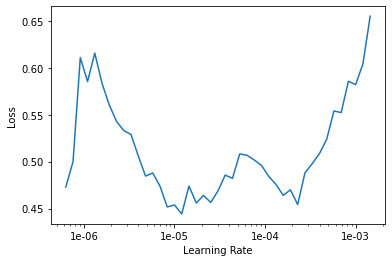

In [51]:
learn.recorder.plot()

In [52]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers.

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [13]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats) 
# used less batches due to error.

In [14]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


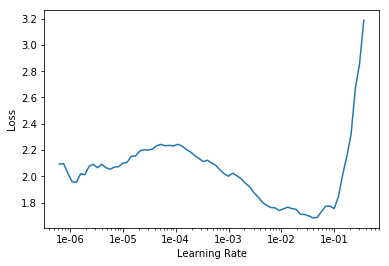

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(8)

In [31]:
learn.save('project-50')

In [32]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [4]:
learn.load('project-50');

NameError: name 'learn' is not defined

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

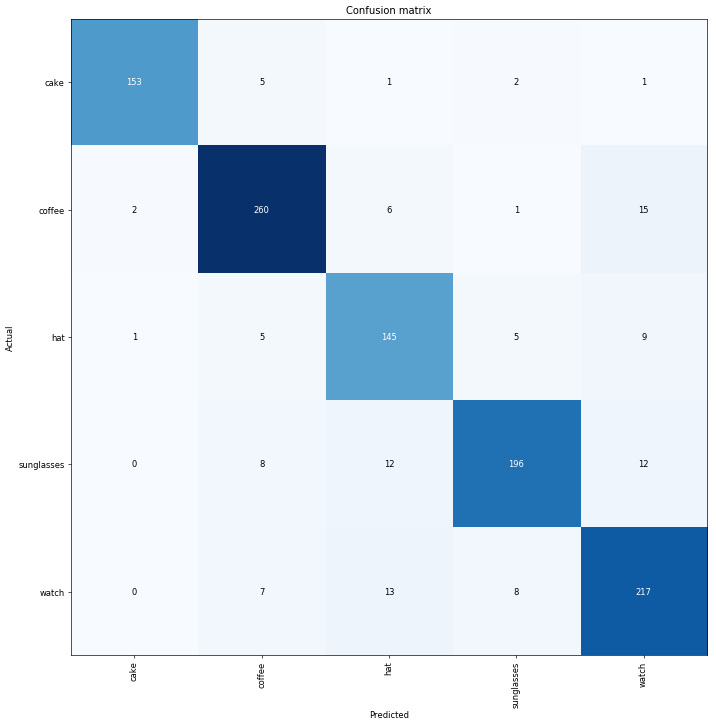

In [35]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [36]:
interp.most_confused(min_val=2)

[('coffee', 'watch', 15),
 ('watch', 'hat', 13),
 ('sunglasses', 'hat', 12),
 ('sunglasses', 'watch', 12),
 ('hat', 'watch', 9),
 ('sunglasses', 'coffee', 8),
 ('watch', 'sunglasses', 8),
 ('watch', 'coffee', 7),
 ('coffee', 'hat', 6),
 ('cake', 'coffee', 5),
 ('hat', 'coffee', 5),
 ('hat', 'sunglasses', 5),
 ('cake', 'sunglasses', 2),
 ('coffee', 'cake', 2)]

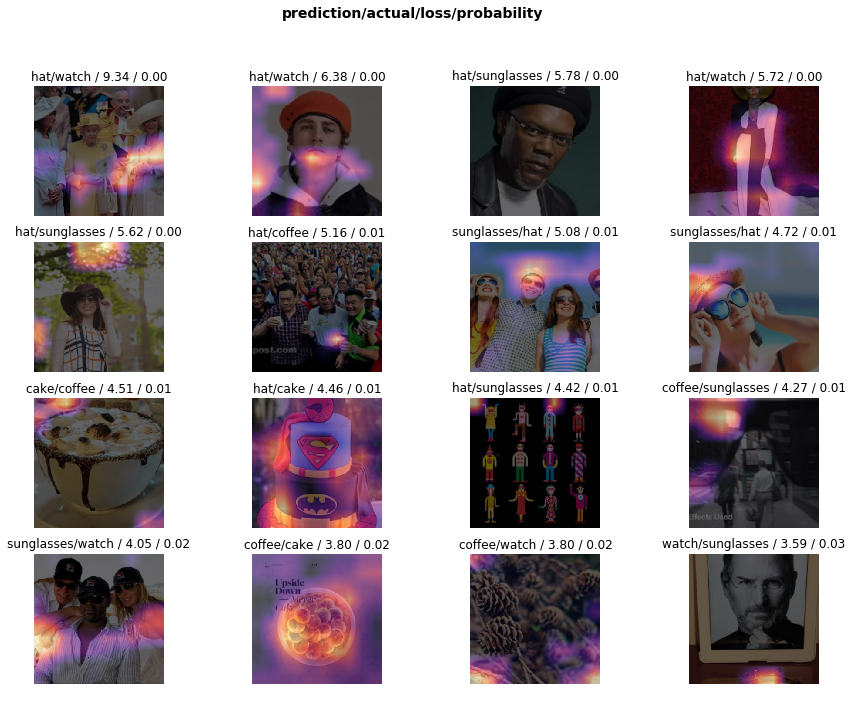

In [37]:
interp.plot_top_losses(16, figsize=(15,11))

# Predicting on new images:

In [246]:
#Loading images and classes:
test1 = open_image('C:/Users/creed/Desktop/project/predict/pic1.jpeg')
test2 = open_image('C:/Users/creed/Desktop/project/predict/pic2.jpeg')
test3 = open_image('C:/Users/creed/Desktop/project/predict/pic3.jpeg')
test4 = open_image('C:/Users/creed/Desktop/project/predict/pic4.jpg')
test5 = open_image('C:/Users/creed/Desktop/project/predict/pic5.jpg')

#the classes:
data.classes

['cake', 'coffee', 'hat', 'sunglasses', 'watch']

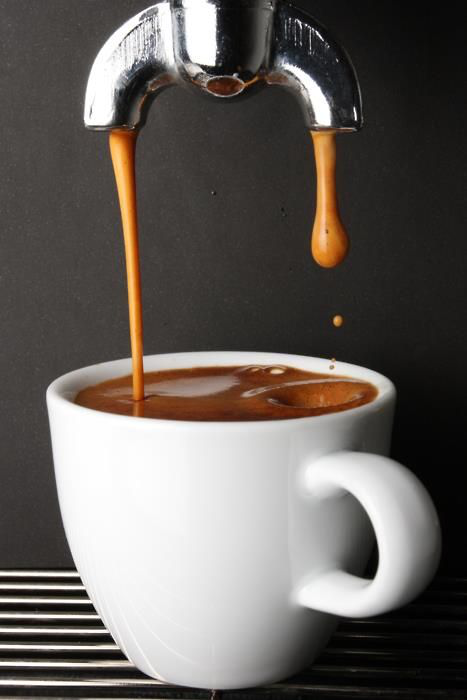

In [247]:
test1

In [248]:
print(learn.predict(test1)[0])

coffee


C:\Users\creed\anaconda3\envs\TensorFlowGPU\lib\site-packages\torch\nn\functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


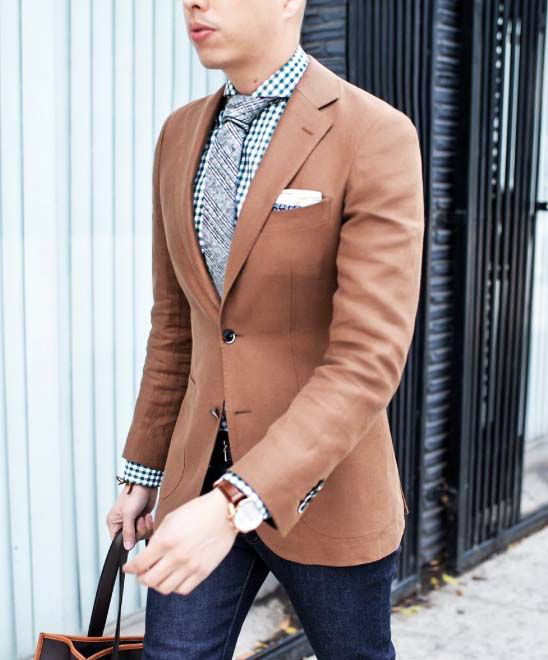

In [249]:
test2

In [250]:
print(learn.predict(test2)[0])

watch


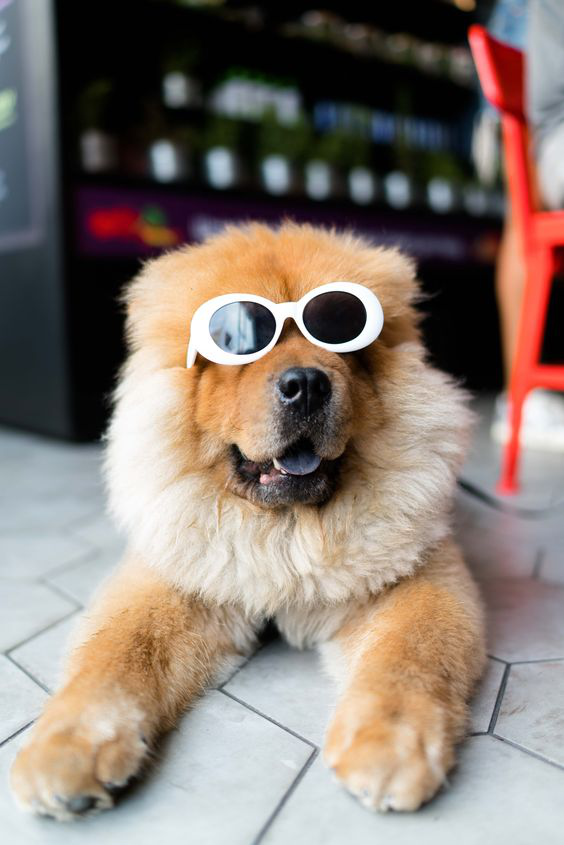

In [251]:
test3

In [252]:
print(learn.predict(test3)[0])

sunglasses


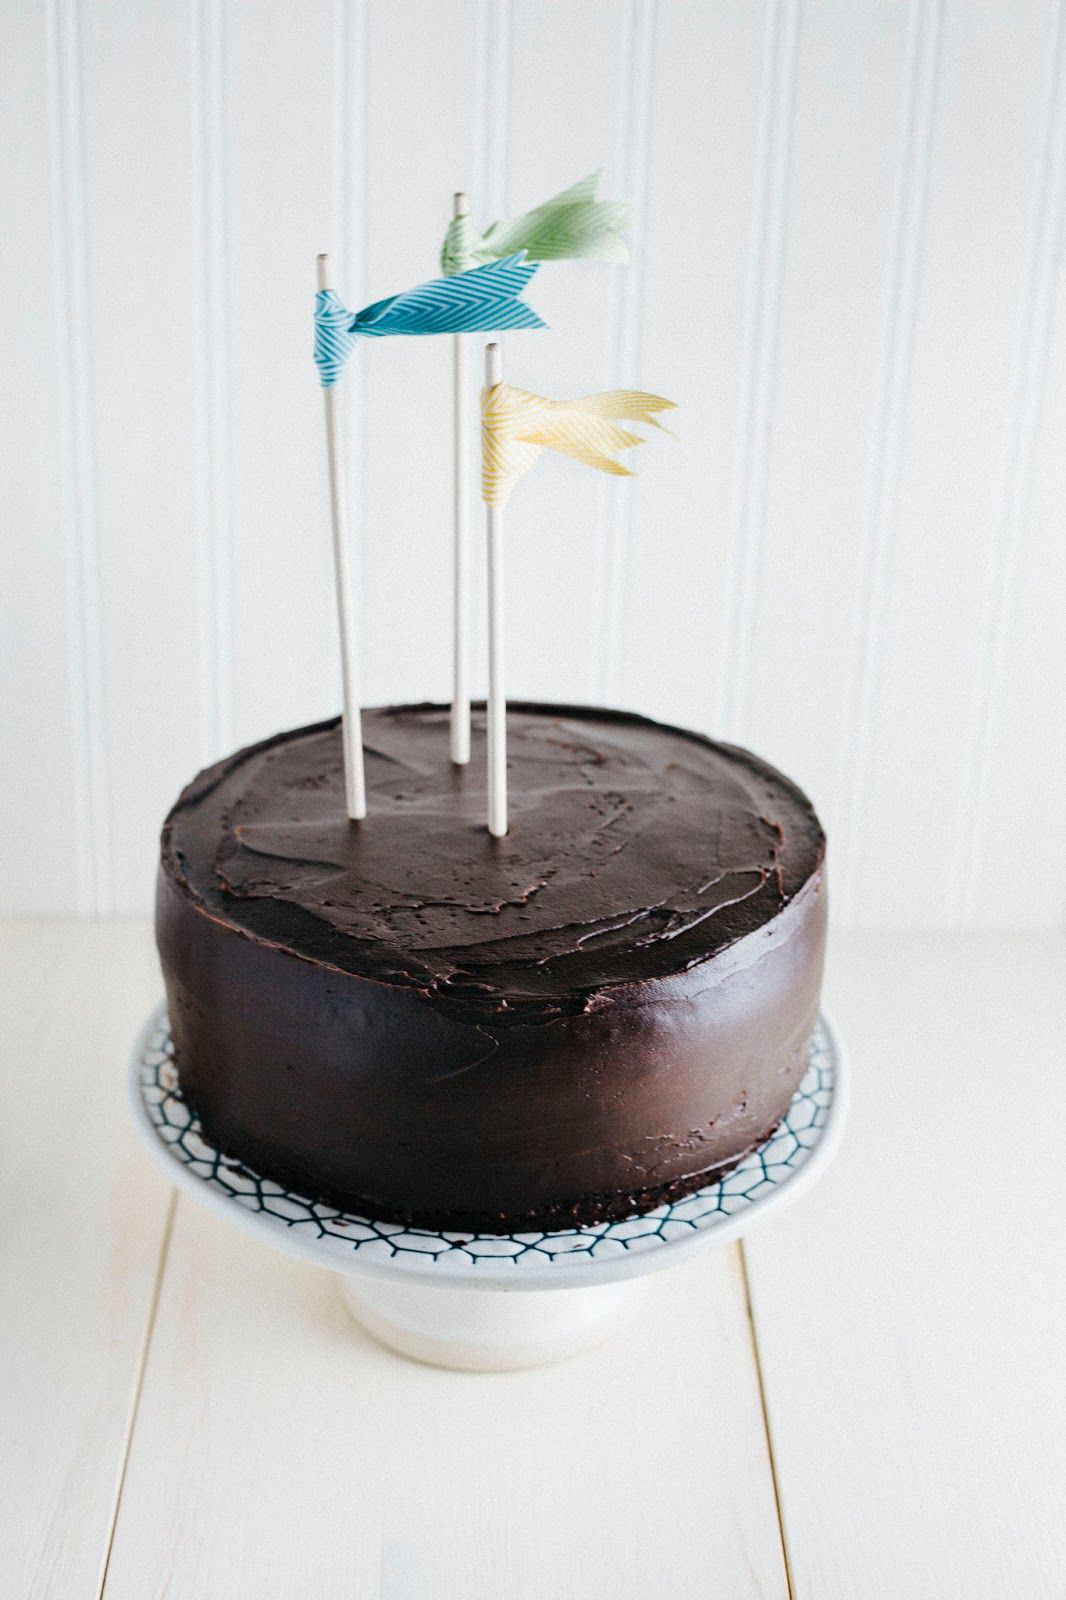

In [253]:
test4

In [254]:
print(learn.predict(test4)[0])

cake


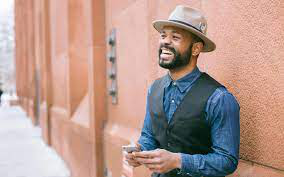

In [255]:
test5

In [256]:
print(learn.predict(test5)[0])

hat
